<a href="https://colab.research.google.com/github/gaborvecsei/Stocks-Pattern-Analyzer/blob/master/Time_Series_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flow:
1. Select a stock ticker
2. Select data range
3. Select tickers which we want to include in the similarity analysis
4. Calculate similarities (selected anchor period to similar length periods in the other tickers)
    - Store raw similarities and also some aggregated measure for every ticker
    - Display top-N (most similar) tickers with the values
5. Display top matches on different charts with past and future values applications
6. Display top-N matches normalized on a single chart with past and future values


Idea list:
- Multiple similarity measures
    - Eucledian distance
    - Manhattan distance
    - Day-to-day increase or decrease (binary classification)
    - Selected time period is bearish or bullish
    - Gain/Loss over the period
    - DTW
- Indicators on sell/buy
    - Based on multiple stock pattern similarities, should be buy or sell
    - Predict the gain if I buy today on close value and sell in 1, 7, 14, ... days
    - "64% of the stocks were bearish after this pattern" OR "Min/Max/Average/median gain after this pattern"


Interesting links:
- https://www.intechopen.com/books/advances-in-data-mining-knowledge-discovery-and-applications/similarity-measures-and-dimensionality-reduction-techniques-for-time-series-data-mining

In [1]:
!pip install yfinance stumpy &> /dev/null

In [146]:
import numpy as np
import pandas as pd
from collections import OrderedDict

from sklearn import metrics
import yfinance
import stumpy

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
stock_tickers = ["AAPL", "MSFT", "TSLA", "BABA"]

In [4]:
stock_close_values = dict()

for t in stock_tickers:
    close_vals = yfinance.Ticker(t).history(period="max", interval="1d")["Close"].values
    stock_close_values[t] = close_vals

In [5]:
# Number of values (days) in the data
{t:x.shape[0] for t, x in stock_close_values.items()}

{'AAPL': 10109, 'BABA': 1593, 'MSFT': 8784, 'TSLA': 2657}

In [6]:
def normalize(x):
    return (x - np.min(x))/np.ptp(x)

------------------------

In [7]:
ANCHOR_STOCK_TICKER = "TSLA"
WIN = 14

In [8]:
anchor_values = stock_close_values[ANCHOR_STOCK_TICKER]

In [9]:
anchor_series_start = len(anchor_values)-WIN-28
anchor_series_end = anchor_series_start + WIN
anchor_series = anchor_values[anchor_series_start:anchor_series_end]
anchor_series_norm = normalize(anchor_series)

In [10]:
window_len = len(anchor_series)

similarities_dict = dict()

for t, v in stock_close_values.items():
    sims = []
    subseries_indexes = []

    for i in range(0, len(v)-window_len, window_len):
        s = normalize(v[i:i+window_len])
        subseries_indexes.append((i, i+window_len))

        sim = sum(abs(anchor_series_norm - s))
        sims.append(sim)
    
    similarities_dict[t] = {"similarities":sims, "indices":subseries_indexes}

In [11]:
for t in similarities_dict.keys():
    vals = similarities_dict[t]["similarities"]
    top_3 = np.argsort(vals)[:3]
    top_3_with_scores = {a:similarities_dict[t]["similarities"][a] for a in top_3}

    print(f"{t} --> {top_3_with_scores}")

AAPL --> {515: 0.8762012814595693, 583: 1.0730331321744075, 604: 1.2203225688709174}
MSFT --> {488: 0.9839884647242827, 560: 1.0584525452098217, 88: 1.0714698592505183}
TSLA --> {165: 1.2830253363660515, 71: 1.3902122882951473, 87: 1.513079219343398}
BABA --> {21: 1.3077816215985236, 41: 1.4099237759713912, 78: 1.5714609384604914}


In [12]:
CHOSEN_CLOSEST_STOCK = "AAPL"
chosen_ticker_values = stock_close_values[CHOSEN_CLOSEST_STOCK]
chosen_ticker_indices = similarities_dict[CHOSEN_CLOSEST_STOCK]["indices"]
chosen_ticker_similarities = similarities_dict[CHOSEN_CLOSEST_STOCK]["similarities"]

In [13]:
closest_series_indexes = chosen_ticker_indices[np.argmin(chosen_ticker_similarities)]

In [14]:
closest_series_start, closest_series_end = closest_series_indexes
closest_series = chosen_ticker_values[closest_series_start:closest_series_end]
closest_series_norm = normalize(closest_series)

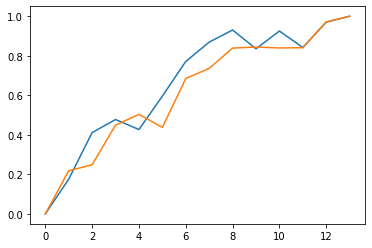

In [15]:
plt.plot(range(0, len(anchor_series_norm)), anchor_series_norm)
plt.plot(range(0, len(closest_series_norm)), closest_series_norm);

In [16]:
FUTURE_WIN = 28
PAST_WIN = 28

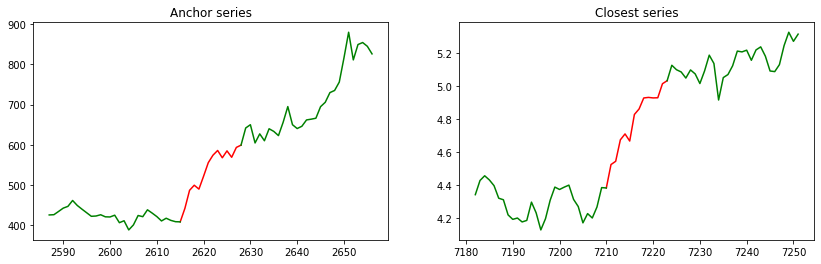

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

indices_anchor = np.arange(anchor_series_start, anchor_series_end, 1)
indices_anchor_future = np.arange(anchor_series_end-1, anchor_series_end+FUTURE_WIN, 1)
anchor_future = anchor_values[anchor_series_end-1:anchor_series_end+FUTURE_WIN]
indices_anchor_past = np.arange(anchor_series_start-PAST_WIN, anchor_series_start+1, 1)
anchor_past = anchor_values[anchor_series_start-PAST_WIN:anchor_series_start+1]

axs[0].plot(indices_anchor, anchor_series, color="r")
axs[0].plot(indices_anchor_future[:len(anchor_future)], anchor_future, color="g")
axs[0].plot(indices_anchor_past, anchor_past, color="g")
axs[0].set_title("Anchor series")

indices_closest = np.arange(closest_series_start, closest_series_end, 1)
indices_closest_future = np.arange(closest_series_end-1, closest_series_end+FUTURE_WIN, 1)
closest_future = chosen_ticker_values[closest_series_end-1:closest_series_end+FUTURE_WIN]
indices_closest_past = np.arange(closest_series_start-PAST_WIN, closest_series_start+1, 1)
closest_past = chosen_ticker_values[closest_series_start-PAST_WIN:closest_series_start+1]

axs[1].plot(indices_closest, closest_series, color="r")
axs[1].plot(indices_closest_future, closest_future, color="g")
axs[1].plot(indices_closest_past, closest_past, color="g")
axs[1].set_title("Closest series");

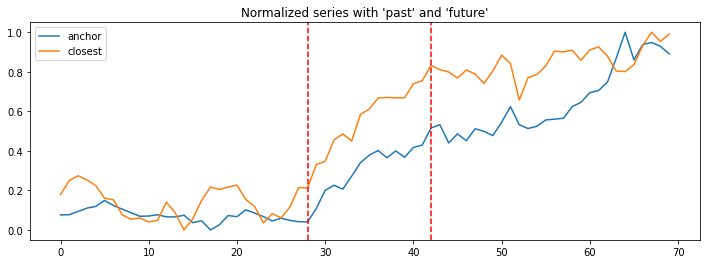

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(normalize(anchor_values[anchor_series_start-PAST_WIN:anchor_series_end+FUTURE_WIN]), label="anchor")
ax.plot(normalize(chosen_ticker_values[closest_series_start-PAST_WIN:closest_series_end+FUTURE_WIN]), label="closest")
ax.axvline(x=PAST_WIN, color="r", linestyle="--")
ax.axvline(x=PAST_WIN+WIN, color="r", linestyle="--")
ax.set_title("Normalized series with 'past' and 'future'")
ax.legend();

-------------------------

In [87]:
class TickerHelper:
    def __init__(self, ticker:str):
        self.name = ticker

        self._data = yfinance.Ticker(self.name).history(period="max", interval="1d")

        self.dates = self._data.index
        self.close_vals = self._data["Close"].values.astype(np.float32)

    def get_windows(self, win_size:int):
        stock_windows = []
        for i in range(0, len(self) - win_size, win_size):
            stock_windows.append(StockWindow(self, i, i+win_size))
        return stock_windows

    def __len__(self):
        return len(self.close_vals)

In [333]:
class StockWindow:
    def __init__(self, ticker:TickerHelper, start_index:int=None, end_index:int=None):
        self.ticker = ticker
        self.start_index = start_index
        self.end_index = end_index

    @property
    def values(self):
        return self.ticker.close_vals[self.start_index:self.end_index]

    def future_window(self, win_size:int):
        # TODO: what if there is no future?
        return StockWindow(self.ticker, self.end_index, self.end_index+win_size)

    def past_values(self, win_size:int):
        # TODO: what if there is no past?
        return StockWindow(self.ticker, self.start_index-win_size, self.start_index)

    @property
    def norm_values(self):
        return normalize(self.values)

    @property
    def dates(self):
        return self.ticker.dates[self.start_index:self.end_index]

    def __len__(self):
        return self.end_index - self.start_index

In [334]:
class DistanceEntry:
    def __init__(self, stock_window:StockWindow, window_index:int, distance:float):
        self.window_index = window_index
        self.distance = distance
        self.stock_window = stock_window

    def __repr__(self):
        return f"window_index: {self.window_index}, distance: {self.distance}"

In [335]:
class Distance:
    def __init__(self, anchor:StockWindow, other_tickers:list):
        self.anchor = anchor
        self.other_tickers = other_tickers

        self.distance_dict = dict()

    @staticmethod
    def similarity_metric(anchor_vals, other_vals):
        assert len(anchor_vals) == len(other_vals), "Length of series should be the same"
        return np.sum(np.abs(anchor_vals - other_vals))

    def compute_distance(self):
        self.distance_dict = {}

        for ticker in self.other_tickers:
            self.distance_dict[ticker.name] = []

            for window in ticker.get_windows(win_size=len(self.anchor)):
                distance_value = self.similarity_metric(self.anchor.norm_values, window.norm_values)
                self.distance_dict[ticker.name].append(distance_value)
        
        return self.distance_dict

    def top_K_matches_for_ticker(self, ticker:TickerHelper, K:int):
        dist_values = self.distance_dict[ticker.name]
        top_K_indices = np.argsort(dist_values)[:K]

        stock_windows = ticker.get_windows(win_size=len(self.anchor))

        distance_entries_sorted = []
        for i in top_K_indices:
            distance_entries_sorted.append(DistanceEntry(stock_windows[i], i, dist_values[i]))

        return distance_entries_sorted

    def top_K(self, K:int, order_by_first_distance_values:bool=True):
        res_dict = {}
        for t in self.other_tickers:
            # TODO: This can run in parallel
            res_dict[t.name] = self.top_K_matches_for_ticker(t, K)
        # Sort the Tickers based on the first distance value
        if order_by_first_distance_values:
            return OrderedDict(sorted(res_dict.items(), key=lambda x: x[1][0].distance))
        else:
            return res_dict

In [336]:
stock_tickers = ["AAPL", "MSFT", "TSLA", "BABA"]

In [337]:
tickers_dict = {k:TickerHelper(k) for k in stock_tickers}

In [338]:
{k:len(v) for k, v in tickers_dict.items()}

{'AAPL': 10109, 'BABA': 1593, 'MSFT': 8784, 'TSLA': 2657}

In [339]:
ANCHOR_STOCK_TICKER = "TSLA"
WINDOW_SIZE = 14

anchor_ticker = tickers_dict[ANCHOR_STOCK_TICKER]
anchor_series = StockWindow(anchor_ticker, len(anchor_ticker)-WINDOW_SIZE, len(anchor_ticker))

In [340]:
dist = Distance(anchor_series, tickers_dict.values())
_ = dist.compute_distance()

In [341]:
top_K_matches = dist.top_K(3, True)

In [342]:
top_K_matches

OrderedDict([('BABA',
              [window_index: 2, distance: 1.0124187469482422,
               window_index: 94, distance: 1.0766174793243408,
               window_index: 52, distance: 1.3220407962799072]),
             ('TSLA',
              [window_index: 168, distance: 1.1316332817077637,
               window_index: 101, distance: 1.3786630630493164,
               window_index: 124, distance: 1.459905982017517]),
             ('AAPL',
              [window_index: 97, distance: 1.1508548259735107,
               window_index: 30, distance: 1.2199829816818237,
               window_index: 550, distance: 1.2739198207855225]),
             ('MSFT',
              [window_index: 182, distance: 1.2255370616912842,
               window_index: 272, distance: 1.3037796020507812,
               window_index: 162, distance: 1.3139054775238037])])

In [343]:
# Get the top series match from the top stock match
closest_stock_window = next(iter(top_K_matches.values()))[0].stock_window